# A3: Pre-processing Flight Data
Interactive-Visual Data Analysis, Fall semester 2024

>Author: Marlon Gelpke 15-532-849

>Submission date: October 26, 2024

>IMPORTANT NOTE FROM THE AUTHOR: Each of the 7 tasks has a "reasoning" section at the end. The required Written Response as outlined in the assignment 3 instructions are written there. It was assumed to be best to see all of the code and visualizations first, before receiving a written explanation of the approach.

# 0 Setup

## 0.1 Installing & importing required Python libraries

In [ ]:
%pip install pandas
%pip install pyflightdata
%pip install matplotlib
%pip install seaborn
%pip install logging
%pip install cartopy

In [282]:
import pandas as pd
from pyflightdata import FlightData
import matplotlib.pyplot as plt
import numpy as np


## 0.2 Loading & inspecting data

In [287]:

# Load the data
file_path = 'data/IVDA_A3_2024_Company_FlightData.csv'
data = pd.read_csv(file_path, sep=';')

# Investigating data structure & understand volume
display(data.head())
print(f'Size of data: {len(data)} rows')


Flight number Aircraft type Departure Destination  Segments Service class  \
0      6,00E+32           NaN       NaN         NaN       1.0             Y   
1      6,00E+32           NaN       NaN         NaN       1.0             B   
2        2I3116           NaN       IQT         TPP       1.0             Y   
3        2I3116           NaN       IQT         TPP       1.0             Y   
4        2I3134           NaN       PCL         LIM       2.0             Y   

  Total Distance [km] CO2 RFI 2 + emissions jet fuel production 15.2% [t]  \
0               913.0                                          0.1045576    
1               913.0                                        0.150562944    
2               504.0                                          0.0916184    
3               504.0                                          0.0916184    
4              1082.0                                          0.1715776    

   Department  
0          HR  
1   Marketing  
2  Operations  
3          IT  
4     Finance

Size of data: 7464 rows


In [284]:
# Understand how many NaN-values we are facing in "Departure" & "Destination"
print(data[['Departure', 'Destination']].isna().sum())

Departure      3204
Destination    3204
dtype: int64


In [285]:
# Show number of unique flight numbers
print(f"{len(data['Flight number'].unique())} unique flight numbers in dataset.")

2299 unique flight numbers in dataset.


## 0.3 Split data into 2 datasets ("data_trips" & "data_flights")

In [286]:
# Setup of a "data_trips" Dataframe, containing all individual trips
data_trips = data[["Flight number", "Aircraft type", "Segments", "Service class", "Department"]]

# Setup of a "data_flights" Dataframe, containing all unique flights
data_flights_temp = data[["Flight number", "Departure", "Destination", "Total Distance [km]", "CO2 RFI 2 + emissions jet fuel production 15.2% [t]"]]
data_flights = data_flights_temp.drop_duplicates(subset='Flight number', keep='last') # As the whole dataset only has about 2k unique flight numbers, the rest can be dropped.


# 1 Reduction of missing data of departure and destination - 4 points

## 1.1 Understand volume of NaN-values and how to find the most recent flight information

In [72]:
# Check for NaN-values in "Destination" and "Departure" for unique flight-numbers
missing_values = data_flights[['Departure', 'Destination']].isna().sum()
print(missing_values)


Departure      1029
Destination    1029
dtype: int64


In [2]:
# Setup of pyflightdata API
fd = FlightData()

# Discover layout of API-response (example)
flight = fd.get_history_by_flight_number('LX1266')

print(flight)
print(flight[0])

print(flight[0]["airport"]["origin"]["code"]["iata"])
print(flight[0]["airport"]["destination"]["code"]["iata"])

[{'identification': {'number': {'default': 'LX1266', 'alternative': '2L1266'}, 'callsign': 'None', 'codeshare': 'None'}, 'status': {'live': False, 'text': 'Scheduled', 'estimated': 'None', 'ambiguous': False, 'generic': {'status': {'text': 'scheduled', 'type': 'departure', 'color': 'gray', 'diverted': 'None'}, 'eventTime': {'utc': 'None', 'local': 'None'}}}, 'aircraft': {'model': {'code': '290', 'text': 'None'}, 'registration': 'None', 'serialNo': 'None', 'age': 'None', 'restricted': 'None', 'availability': {'serialNo': 'None', 'age': 'None'}}, 'owner': 'None', 'airline': {'name': 'Swiss', 'code': {'iata': 'LX', 'icao': 'SWR'}}, 'airport': {'origin': {'name': 'Zurich Airport', 'code': {'iata': 'ZRH', 'icao': 'LSZH'}, 'position': {'latitude': 47.464722, 'longitude': 8.549167, 'country': {'name': 'Switzerland', 'code': 'CH'}, 'region': {'city': 'Zurich'}}, 'timezone': {'name': 'Europe/Zurich', 'offset': 3600, 'abbr': 'CET', 'abbrName': 'Central European Time', 'isDst': False}, 'visible':

In [79]:
most_recent_departure = None
most_recent_index = -1

# Iterate over the API response to find the flight with the most recent departure time
for index, flight in enumerate(flight):
    # Get the departure time in milliseconds
    departure_time_millis = flight['time']['scheduled']['departure_millis']
    
    # Check if this is the most recent departure
    if most_recent_departure is None or departure_time_millis > most_recent_departure:
        most_recent_departure = departure_time_millis
        most_recent_index = index

# Output the index and departure time of the most recent flight
print(f"Most recent departure is at index: {most_recent_index}, Departure time (milliseconds): {most_recent_departure}")


Most recent departure is at index: 0, Departure time (milliseconds): 1730268300000


## 1.2 Retrieve missing "Departure" and "Destination" values

In [83]:
# Setup of function
def retrieve_missing_info(row):
    if (pd.isnull(row['Departure']) or pd.isnull(row['Destination'])):
        try:
            if len(fd.get_flights(row['Flight number'])) > 0:
                flight_info = fd.get_history_by_flight_number(row['Flight number'])  # Retrieve flight information based on past flights.
                if len(flight_info) > 0:
                    row['Departure'] = flight_info[0]["airport"]["origin"]["code"]["iata"] # Get most recent departure IATA-code
                    row['Destination'] = flight_info[0]["airport"]["destination"]["code"]["iata"] # Get most recent destination IATA-code
                    print(f"{row.name}/{len(data)}")
        except Exception as e:
            print(f"Error retrieving departure for flight {row['Flight number']}: {e}")
    return row

In [84]:
# Run retrieve_missing_inf() across all rows of data_flights dataframe
t1_data_flights = data_flights.apply(retrieve_missing_info, axis=1)

48/7464
54/7464
60/7464
61/7464
63/7464
65/7464
69/7464
HTML code 402 - Retry in 10 seconds...
72/7464
78/7464
79/7464
88/7464
89/7464
HTML code 402 - Retry in 10 seconds...
91/7464
95/7464
98/7464
HTML code 402 - Retry in 10 seconds...
102/7464
104/7464
HTML code 402 - Retry in 10 seconds...
116/7464
120/7464
153/7464
HTML code 402 - Retry in 10 seconds...
156/7464
159/7464
160/7464
HTML code 402 - Retry in 10 seconds...
202/7464
203/7464
204/7464
HTML code 402 - Retry in 10 seconds...
231/7464
241/7464
HTML code 402 - Retry in 10 seconds...
256/7464
269/7464
HTML code 402 - Retry in 10 seconds...
292/7464
293/7464
312/7464
321/7464
HTML code 402 - Retry in 10 seconds...
324/7464
339/7464
351/7464
357/7464
360/7464
HTML code 402 - Retry in 10 seconds...
367/7464
372/7464
HTML code 402 - Retry in 10 seconds...
377/7464
387/7464
HTML code 402 - Retry in 10 seconds...
HTML code 402 - Retry in 10 seconds...
414/7464
416/7464
417/7464
HTML code 402 - Retry in 10 seconds...
423/7464
424/746

Departure      417
Destination    417
dtype: int64


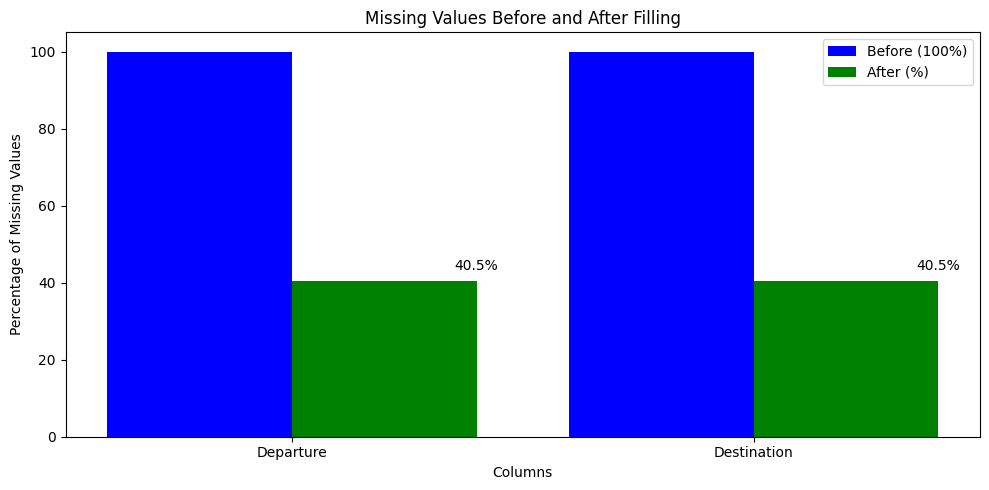

In [102]:

# Plot before filling missing values
missing_before = missing_values

# After filling missing values
missing_after = t1_data_flights[['Departure', 'Destination']].isnull().sum()

print(missing_after)

# Plotting as bar chart
labels = ['Departure', 'Destination']
before_counts = [missing_before['Departure'], missing_before['Destination']]
after_counts = [missing_after['Departure'], missing_after['Destination']]

# Calculate percentage of the After counts relative to Before counts
percentage_after = [(count / before) * 100 for count, before in zip(after_counts, before_counts)]

x = np.arange(len(labels))

# Plotting the bar chart
plt.figure(figsize=(10, 5))  # Adjusting figure size
plt.bar(x, [100] * len(before_counts), width=0.4, label='Before (100%)', color='blue', align='center')  # 100% for Before
plt.bar(x + 0.4, percentage_after, width=0.4, label='After (%)', color='green', align='center')

plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Before and After Filling')
plt.xticks(x + 0.2, labels)
plt.legend()

# Adding value annotations on the "After" bars
for i in range(len(percentage_after)):
    plt.text(i + 0.6, percentage_after[i] + 2, f'{percentage_after[i]:.1f}%', 
             ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()  # Adjust layout to make it look better
plt.show()




Before: 1029
After: 417

## 1.3 Clean up after data retrieval

In [103]:
# Drop rows containing "NaN" in data_flights Dataframe
columns_to_check = ['Departure', 'Destination']
t1_data_flights_cleaned = data_flights.dropna(subset=columns_to_check)

print(f"{len(t1_data_flights_cleaned)} unqiue flights remain after cleanup.")

# Save progress to file
t1_data_flights_cleaned.to_csv('data/t1_FlightData.csv', index=False, sep=';')
data_trips.to_csv('data/t1_TripData.csv', index=False, sep=';')

1882 unqiue flights remain after cleanup.


## 1.4 Reasoning

Initially, an analysis revealed that there are only 2,299 unique flight numbers in the dataset, confirmed through the command `print(len(data['Flight number'].unique())`. Given that the flight number serves as a unique identifier, the dataset was segmented into two distinct datasets: a trips dataset (`data_trips`) and a flights dataset (`data_flights`). By removing duplicates from the `data_flights` dataset, the effort required to identify missing departure and destination information (denoted as "NaN" in pandas) was significantly minimized.

To fetch the missing departure and destination data, the Python library `pyflightdata` was employed, specifically the function `get_history_by_flight_number(flight_number)`. This function retrieves a list of occurrences for a given flight number, including relevant IATA codes.

The function `get_history_by_flight_number(flight_number)` may return multiple entries for the same flight number, each potentially featuring different departure and destination codes. For accuracy, the first entry in the list was selected as it represents the most recent and presumably the most reliable data source (refer to section 1.1 for supporting evidence).
The developed function `retrieve_missing_info()` was then utilized to iterate through the entire dataset, effectively filling in the missing values. This approach reduced the number of flights with NaN values from 1,029 to 417 for both departure and destination.

However, some flights resulted in an HTTP-402 error when using the `pyflightdata`, indicating that a paid account is necessary to access the requested information. To further decrease the number of flights with NaN values, acquiring such an account would be required. This action was not undertaken for this task, which led to the retention of some unique flight numbers still containing NaN values. Consequently, those rows were eliminated (as detailed in section 1.3) to avoid complicating subsequent tasks.

# 2 Airport code errors - 1 point

In [104]:
# Load airport data
data_airports = pd.read_csv('data/iata-icao.csv')

# Load data_flights dataset as pandas df
data_flights = pd.read_csv('data/t1_FlightData.csv', sep=';')

## 2.1 Find airport code errors

In [105]:
# Convert the valid IATA codes to a set for quick lookup
valid_iata_set = set(data_airports['iata'].str.upper())  # Convert to uppercase for consistency

# Add "IATA-Error" column for tracking
data_flights["IATA-Error"] = 0

# Function to check and correct IATA codes
def check_airport_codes(row):
    if row['Departure'] not in valid_iata_set:
        row['Departure'] = None
        row["IATA-Error"] = 1
    if row['Destination'] not in valid_iata_set:
        row['Destination'] = None
        row["IATA-Error"] = 1
    return row

error_data_before = data_flights.apply(check_airport_codes, axis=1)


## 2.2 Resolving IATA-Errors

In [92]:
# Definition of function
def solve_iata_error(row):
    if row['IATA-Error'] == 1:
        try:
            if len(fd.get_flights(row['Flight number'])) > 0:
                flight_info = fd.get_history_by_flight_number(row['Flight number'])  # Retrieve flight information based on past flights.
                if len(flight_info) > 0:
                    row['Departure'] = flight_info[-1]["airport"]["origin"]["code"]["iata"]  # Adjust this based on actual response structure
                    row['Destination'] = flight_info[-1]["airport"]["destination"]["code"]["iata"]  # Adjust this based on actual response structure
                    row['IATA-Error'] = 0
                    print(f"{row.name}/{len(error_data_before)}")
        except Exception as e:
            print(f"Error retrieving departure for flight {row['Flight number']}: {e}")
    return row

In [93]:
# Apply solve_iata_error() function to all rows of dataframe
error_data_after = error_data_before.apply(solve_iata_error, axis=1)

69/1882
253/1882
447/1882
489/1882
644/1882
HTML code 402 - Retry in 10 seconds...
1056/1882
1365/1882
1366/1882
1367/1882
1372/1882
1373/1882
HTML code 402 - Retry in 10 seconds...
1427/1882
1472/1882
HTML code 402 - Retry in 10 seconds...
1540/1882
1574/1882
1575/1882
1711/1882
HTML code 402 - Retry in 10 seconds...
1872/1882
1878/1882


In [106]:
# Show final outcome by comparing how many errors existed before, compared to after cleanup
missing_before = (error_data_before['IATA-Error'] == 1).sum()

missing_after = (error_data_after['IATA-Error'] == 1).sum()

print(f"Rows with faulty IATA-codes before cleanup: {missing_before}")
print(f"Rows with faulty IATA-codes after cleanup: {missing_after}")

Rows with faulty IATA-codes before cleanup: 34
Rows with faulty IATA-codes after cleanup: 15


## 2.3 Plotting airport error development

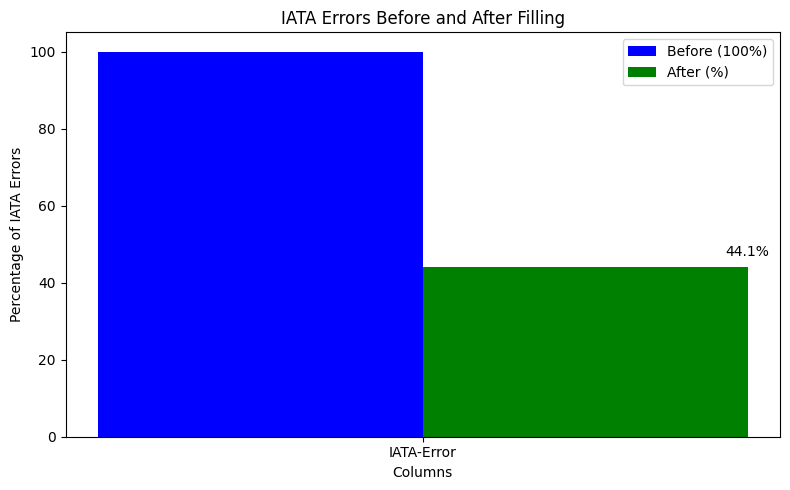

In [108]:
# Plot before filling missing values
missing_before = (error_data_before['IATA-Error'] == 1).sum()

# After filling missing values
missing_after = (error_data_after['IATA-Error'] == 1).sum()

# Plotting
labels = ['IATA-Error']
before_counts = [missing_before]
after_counts = [missing_after]

# Calculate percentage of the After count relative to Before count
percentage_after = [(count / before) * 100 for count, before in zip(after_counts, before_counts)]

x = range(len(labels))

# Plotting
plt.figure(figsize=(8, 5))  # Adjusting figure size
plt.bar(x, [100] * len(before_counts), width=0.4, label='Before (100%)', color='blue', align='center')  # Before as 100%
plt.bar([p + 0.4 for p in x], percentage_after, width=0.4, label='After (%)', color='green', align='center')

plt.xlabel('Columns')
plt.ylabel('Percentage of IATA Errors')
plt.title('IATA Errors Before and After Filling')
plt.xticks([p + 0.2 for p in x], labels)
plt.legend()

# Adding value annotations on the "After" bars
for i in range(len(percentage_after)):
    plt.text(i + 0.6, percentage_after[i] + 2, f'{percentage_after[i]:.1f}%', 
             ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()  # Adjust layout to make it look better
plt.show()

In [109]:
# Drop rows containing "NaN" in data_flights Dataframe
t2_data_flights_cleaned = error_data_after[error_data_after['IATA-Error'] != 1]
t2_data_flights_cleaned = t2_data_flights_cleaned.drop('IATA-Error', axis=1)

print(f"Reduced size from {len(error_data_after)} to {len(t2_data_flights_cleaned)}.")

Reduced size from 1882 to 1867.


In [110]:
# Save the updated DataFrame to file
t2_data_flights_cleaned.to_csv('data/t2_FlightData.csv', index=False)  # Replace with your desired output path

## 2.4 Reasoning

IATA-codes are known and publicly available information (e.g., https://github.com/ip2location/ip2location-iata-icao/blob/master/iata-icao.csv).

In order to check for errors, the approach was taken to simply compare each IATA-code of the `data_flights` Dataframe with the above-mentioned list (see function `check_airport_codes()`). Each code (no matter because of which error) that doesn't appear on this list is considered faulty and flagged with the respective column "IATA-Error".

In a second step, the function `solve_iata_error()` checks each flagged row and resolves it by fetching the correct information from the `pyflightdata` function `get_history_by_flight_number(flight_number)`, as similarly done in step 1.

Through this, a significant improvement can be seen: from 34 errors to 15.

For some flights, the ``pyflightapi`` returns a HTTP-402 error indicating that a paid account is required to fetch requested information. To further reduce the amount of flights with NaN-values, such an account would be required. This measure was not taken for this task, and therefore some unique flight-numbers with NaN-values remain. These rows were dropped (see ch. 1.3) to not further interfere with upcoming tasks.

# 3 Derive latitude and longitude- 1 point

In [116]:
# Load your data_flights dataset as DataFrame
data_flights = pd.read_csv('data/t2_FlightData.csv')

# Load airport dataset as DataFrame
airport_data = pd.read_csv('data/iata-icao.csv')

In [117]:
# Initialize new columns with None
data_flights['dep_lat'] = None
data_flights['dep_lon'] = None
data_flights['dest_lat'] = None
data_flights['dest_lon'] = None

In [118]:
def get_lat_long_by_iata(iata_code, df):
    """Retrieve latitude and longitude for a given IATA code."""
    # Filter the DataFrame for the given IATA code
    airport_info = df[df['iata'].str.upper() == iata_code.upper()]

    if not airport_info.empty:
        # Extract latitude and longitude
        latitude = airport_info['latitude'].values[0]
        longitude = airport_info['longitude'].values[0]
        return latitude, longitude
    else:
        return None, None  # Return None if IATA code is not found

In [119]:
# Iterate through the data_flights DataFrame and fill the new columns
for index, row in data_flights.iterrows():
    if pd.isna(row['Departure']) or pd.isna(row['Destination']):
        pass
    else:
        dep_iata = row['Departure']
        dest_iata = row['Destination']
        
        # Get latitude and longitude for the departure IATA code
        dep_lat, dep_long = get_lat_long_by_iata(dep_iata, airport_data)
        data_flights.at[index, 'dep_lat'] = dep_lat
        data_flights.at[index, 'dep_lon'] = dep_long
        
        # Get latitude and longitude for the destination IATA code
        dest_lat, dest_long = get_lat_long_by_iata(dest_iata, airport_data)
        data_flights.at[index, 'dest_lat'] = dest_lat
        data_flights.at[index, 'dest_lon'] = dest_long



In [125]:
# It seems, there are some departure / destination codes which don't appear in the data_airports file provided. 
missing_values = data_flights[['dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']].isna().sum()
print(missing_values)

rows_with_nan = data_flights[data_flights[['dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']].isnull().any(axis=1)]

print(rows_with_nan[['Flight number', 'Departure', 'Destination', 'dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']])

rows_with_dme = data_airports[data_airports['iata'] == 'TFS']
print(rows_with_dme)

dep_lat     5
dep_lon     5
dest_lat    8
dest_lon    8
dtype: int64
     Flight number Departure Destination  dep_lat  dep_lon dest_lat dest_lon
445          EK129       DXB         DME  25.2528  55.3644     None     None
487          EW253       TFS         CGN     None     None  50.8659  7.14274
640         IB3946       MAD         TFN  40.4719 -3.56264     None     None
1357          NH23       HND         ITM  35.5533  139.781     None     None
1358          NH54       CTS         HND     None     None  35.5533  139.781
1359          NH55       HND         CTS  35.5533  139.781     None     None
1363         NH864       GMP         HND     None     None  35.5533  139.781
1364         NT621       SPC         TFN  28.6265 -17.7556     None     None
1418        OZ1055       HND         GMP  35.5533  139.781     None     None
1461        S72507       DME         OVB     None     None  55.0126  82.6507
1561         TC130       DAR         NPY -6.87811  39.2026     None     None
1857   

In [128]:
# Drop rows containing "NaN" in data_flights Dataframe for cols latitude & longitude
columns_to_check = ['dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']
t3_data_flights_cleaned = data_flights.dropna(subset=columns_to_check)

print(f"Number of rows before cleanup: {len(data_flights)}")
print(f"Number of rows after cleanup: {len(t3_data_flights_cleaned)}")

Number of rows before cleanup: 1867
Number of rows after cleanup: 1854


In [127]:
# Save the updated DataFrame
t3_data_flights_cleaned.to_csv('data/t3_FlightData.csv', index=False) 

## 3.1 Reasoning
Four new columns in the `data_flights` Dataframe were created to facilitate the storage of latitude & longitude information for both, departure and destination.

The longitude and latitude data was fetched using the provided `iata-icao.csv` (https://github.com/ip2location/ip2location-iata-icao/blob/master/iata-icao.csv).

It seems `pyflightdata` returns some IATA-codes (5 departures and 8 destinations) which don't appear in `iata-icao.csv`. The assumption taken at this place is, that we take `iata-icao.csv` as the single source of truth, therefore all remaining rows containing NaN for latitude & longitude values (wherever they couldn't be fetched) are dropped to not further interfere with upcoming tasks. This was the case for 13 rows.

# 4 Total distance outlier detection - 3 points

In [175]:
# Setup
data_flights = pd.read_csv('data/t3_FlightData.csv')

## 4.1 Recalculate Air distance with Geopy

In [211]:
from geopy.distance import geodesic, great_circle

data_flights["Air Distance [km]"] = None      

# Setup calculation function 
def calc_air_dist(row):
    if pd.isna(row['dep_lat']) or pd.isna(row['dep_lon']):
        row["Air Distance [km]"] = None
    else:
        dep = (row["dep_lat"], row["dep_lon"])
        dest = (row["dest_lat"], row["dest_lon"])
        try:
            # row["Air Distance [km]"] = round(geodesic(dep, dest).km)
            row["Air Distance [km]"] = round(great_circle(dep, dest).km)
        except:
            row["Air Distance [km]"] = None
    return row


In [212]:
# Apply calc_air_dist() to the whole dataset
tmp_dist_data_before = data_flights.apply(calc_air_dist, axis=1)

In [213]:
# Check how many rows of data remain with ['Air Distance [km]'] == None
missing_before = (tmp_dist_data_before['Air Distance [km]'] == None).sum()

print(missing_before)


0


In [219]:
# Get a feeling for the distribution of the distance data
print(tmp_dist_data_before['Air Distance [km]'].describe())

percentiles = tmp_dist_data_before['Air Distance [km]'].quantile([0.05, 0.25, 0.5, 0.75, 0.95])
print(percentiles)

count     1854.000000
mean      2582.701187
std       2942.793443
min          0.000000
25%        603.000000
50%       1073.000000
75%       3874.000000
max      18363.000000
Name: Air Distance [km], dtype: float64
0.05     286.00
0.25     603.00
0.50    1073.00
0.75    3874.00
0.95    9094.55
Name: Air Distance [km], dtype: float64


## 4.2 Visualization of distribution

In [187]:
from geopy.distance import great_circle

#function to calculate the air distance between two points
def recalc_distance(row):
    try: 
        lat_dept = data_airports.loc[data_airports['iata'] == row['Departure'], 'latitude'].values[0]
        long_dept = data_airports.loc[data_airports['iata'] == row['Departure'], 'longitude'].values[0]
        lat_dest = data_airports.loc[data_airports['iata'] == row['Destination'], 'latitude'].values[0]
        long_dest = data_airports.loc[data_airports['iata'] == row['Destination'], 'longitude'].values[0]
        return great_circle((lat_dept, long_dept), (lat_dest, long_dest)).kilometers
    except:
        return 'toremove'

Lower bound:  -13151.5
Upper bound:  22812.5
Number of outliers: 4


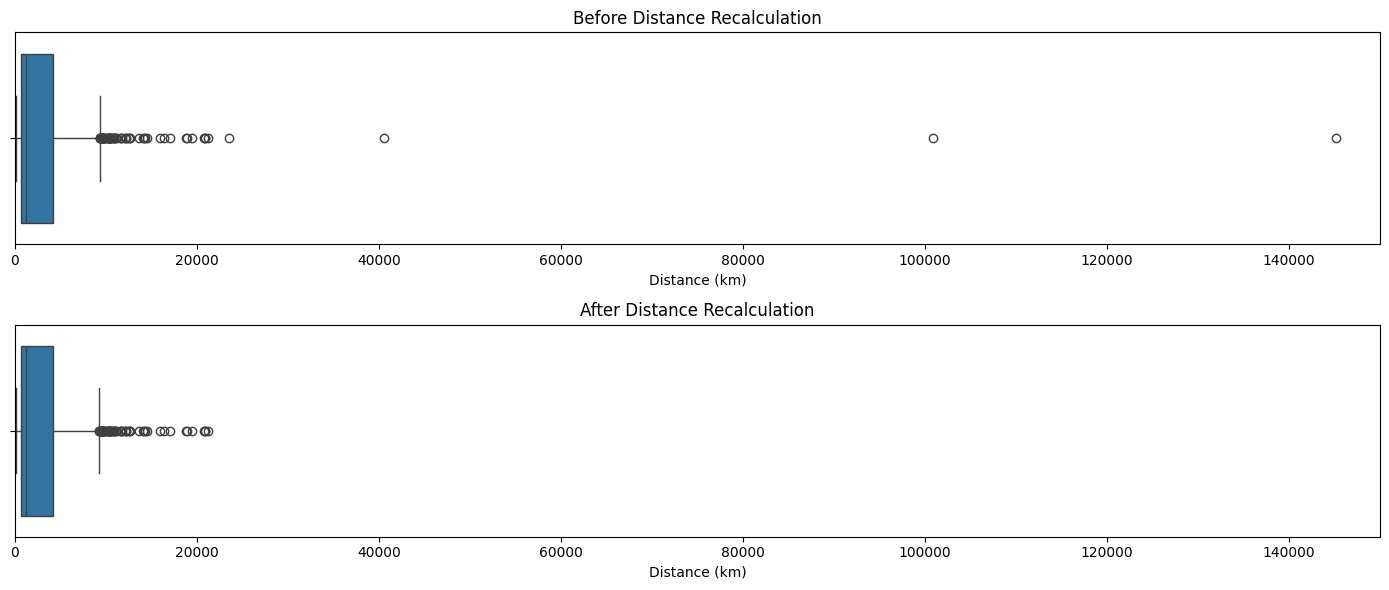


Before distance recalculation:
count      1823.000000
mean       2938.444871
std        5254.167669
min         163.000000
25%         702.000000
50%        1185.000000
75%        4164.000000
max      145129.000000
Name: Total Distance [km], dtype: float64

After distance recalculation:
count     1823.000000
mean      2781.165960
std       3205.718297
min        163.000000
25%        702.000000
50%       1183.000000
75%       4141.000000
max      21274.000000
Name: Total Distance [km], dtype: float64


In [237]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the distance column is numeric
data_flights['Total Distance [km]'] = pd.to_numeric(data_flights['Total Distance [km]'], errors='coerce')

# Identify outliers using the IQR method
q05 = data_flights['Total Distance [km]'].quantile(0.05)
q95 = data_flights['Total Distance [km]'].quantile(0.95)
IQR = q95 - q05

# Calculate lower and upper bounds for outliers
lower_bound = q05 - 1.5 * IQR
upper_bound = q95 + 1.5 * IQR

print("Lower bound: ", lower_bound)
print("Upper bound: ", upper_bound)

# Identify outliers
outliers = data_flights[(data_flights['Total Distance [km]'] < lower_bound) | 
                                (data_flights['Total Distance [km]'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")

# Recalculate distances for outliers (assumed to have recalc_distance function defined)
data_recalculated = data_flights.copy()
outlier_indices = outliers.index
data_recalculated.loc[outlier_indices, 'Total Distance [km]'] = outliers.apply(recalc_distance, axis=1)

# Visualize before and after comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))

# Boxplot before recalculation
# sns.boxplot(x=data_after_long_lat['Total Distance [km]'], ax=ax1, showfliers=True)
sns.boxplot(x='Total Distance [km]', data=data_flights, ax=ax1, showfliers=True)

ax1.set_title('Before Distance Recalculation')
ax1.set_xlabel('Distance (km)')

# Calculate the actual data range excluding outliers
valid_data = data_recalculated[(data_recalculated['Total Distance [km]'] >= lower_bound) &
                                (data_recalculated['Total Distance [km]'] <= upper_bound)]

# Set the whiskers to the actual min and max of valid data
sns.boxplot(x=valid_data['Total Distance [km]'], ax=ax2, showfliers=True)
ax2.set_title('After Distance Recalculation')
ax2.set_xlabel('Distance (km)')

# Set x-axis limits
ax1.set_xlim(0, 150000)
ax2.set_xlim(0, 150000)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nBefore distance recalculation:")
print(data_flights['Total Distance [km]'].describe())

print("\nAfter distance recalculation:")
print(data_recalculated['Total Distance [km]'].describe())


In [238]:
# Save the updated DataFrame
valid_data.to_csv('data/t4_FlightData.csv', index=False) 

## 4.2 Reasoning

>Keep in mind, the dataset was split to reveal unique flight numbers. The outlier detection was run on unique flight numbers / information, instead on trips.

As mentioned in the lecture, boxplots are the main tool to visualize a distribution and its outliers. The first step is to detect outliers by chosing the intervals suitable for this task.

As shown in ch. 4.1, the distribution of flight distances are as follows:

- $0.05:     286 km$
- $0.25:     603 km$
- $0.50:    1073 km$
- $0.75:    3874 km$
- $0.95:    9094.55 km$

For this task, the assumption was taken that suitable quantiles could be Q1 with 0.05 and Q3 with 0.95.

In a next step, the IQR-method ($IQR = Q3 - Q1$) was chosen to calculate the lower ($Q1 - 1.5 * IQR$) and upper ($Q3 + 1.5 * IQR$) bounds: $-13'151.5$ (lower) & $22'812.5$ (upper).

Then, outliers were detected and saved in the variable `outliers` (4 in total) and sent to an additional step of recalculation, using the `geopy.distance.great_circle()` function, through which, indeed their distances are set to the correct value and we end up with a tidier, more truthful visualization (see visualization "After Distance Recalculation" without the 4 outliers).



# 5. Feature extraction: Identifying potential layovers - 6 points

## 5.1 Setup & Country / Continent mapping

In [ ]:
!pip install countryinfo


In [175]:
# Setup
data_airports = pd.read_csv('data/iata-icao.csv')

In [326]:
from countryinfo import CountryInfo

data_airports['continent'] = None

def get_continent(row):
    try:
        country_code = row['country_code']
        country_info = CountryInfo(country_code)
        continent = country_info.region()  # Get continent/region
        row['continent'] = continent
        return row
    except Exception as e:
        return row  # Return None if country code is invalid or not found



In [327]:
# Apply the function to fill the new continent column with data
data_airports = data_airports.apply(get_continent, axis=1)

# Display the DataFrame
display(data_airports)

country_code         region_name iata  icao  \
0              AE            Abu Zaby  AAN  OMAL   
1              AE            Abu Zaby  AUH  OMAA   
2              AE            Abu Zaby  AYM   NaN   
3              AE            Abu Zaby  AZI  OMAD   
4              AE            Abu Zaby  DHF  OMAM   
...           ...                 ...  ...   ...   
8950           ZW            Masvingo  MVZ  FVMV   
8951           ZW  Matabeleland North  HWN  FVWN   
8952           ZW  Matabeleland North  VFA  FVFA   
8953           ZW  Matabeleland North  WKI  FVWT   
8954           ZW            Midlands  GWE  FVTL   

                              airport  latitude  longitude continent  
0        Al Ain International Airport   24.2617    55.6092      Asia  
1     Abu Dhabi International Airport   24.4330    54.6511      Asia  
2            Yas Island Seaplane Base   24.4670    54.6103      Asia  
3         Al Bateen Executive Airport   24.4283    54.4581      Asia  
4                  Al Dhafra Air Base   24.2482    54.5477      Asia  
...                               ...       ...        ...       ...  
8950                 Masvingo Airport  -20.0553    30.8591    Africa  
8951     Hwange National Park Airport  -18.6299    27.0210    Africa  
8952           Victoria Falls Airport  -18.0959    25.8390    Africa  
8953              Hwange Town Airport  -18.3630    26.5198    Africa  
8954               Thornhill Air Base  -19.4364    29.8619    Africa  

[8955 rows x 8 columns]

In [328]:
# Determine if there are any airports with missing continent data
missing_continent = (data_airports['continent'] == None).sum()

print("Number of airports missing continent data: ", missing_continent)

Number of airports missing continent data:  0


In [318]:
# Save the updated DataFrame data_airports
data_airports.to_csv('data/t5_AirportData.csv', index=False) 

## 5.2 Helper Functions & Flight times

In [174]:
# Some helper functions
def convert_to_utc(timestamp):
    return pd.to_datetime(timestamp, unit='s', utc=True)

def helper_get_info(row):
    departure_iata = row['Departure']
    destination_iata = row['Destination']
        
    # Get the continent for departure and destination airports
    departure_airport = data_airports[data_airports['iata'] == departure_iata]
    destination_airport = data_airports[data_airports['iata'] == destination_iata]

    # Get continent data for departure and destination
    departure_continent = departure_airport['continent'].values[0]  # Get the first value
    destination_continent = destination_airport['continent'].values[0]  # Get the first value

    return departure_iata, destination_iata, departure_continent, destination_continent

In [4]:
# Save departure & arrival times for every flight
def flight_times(row):
    try:
        if len(fd.get_flights(row['Flight number'])) > 0:
            flight_info = fd.get_history_by_flight_number(row['Flight number'])  # Retrieve flight information based on past flights.
            if len(flight_info) > 0:
                arrival_time_secs = flight_info[0]['time']['scheduled']['arrival'] # Get most recent arrival time
                departure_time_secs = flight_info[0]['time']['scheduled']['departure'] # Get most recent departure time
                row['arrival_time_secs'] = arrival_time_secs
                row['departure_time_secs'] = departure_time_secs
                row['arrival_time_utc'] = convert_to_utc(arrival_time_secs)
                row['departure_time_utc'] = convert_to_utc(departure_time_secs)
                print(f"{row.name}/{len(data_flights)}")

                return row
    except Exception as e:
        print(f"Error retrieving departure for flight {row['Flight number']}: {e}")

In [39]:
# Setup of new dataframe for flight 
data_flights = pd.read_csv('data/t4_FlightData.csv')

data_flight_times_tmp = data_flights
data_flight_times_tmp['arrival_time_secs'] = None
data_flight_times_tmp['departure_time_secs'] = None
data_flight_times_tmp['arrival_time_utc'] = None
data_flight_times_tmp['departure_time_utc'] = None


In [40]:
data_flight_times = data_flight_times_tmp.apply(flight_times, axis=1)

0/1823
4/1823
5/1823
6/1823
HTML code 402 - Retry in 10 seconds...
7/1823
8/1823
9/1823
14/1823
HTML code 402 - Retry in 10 seconds...
18/1823
19/1823
20/1823
HTML code 402 - Retry in 10 seconds...
21/1823
23/1823
25/1823
26/1823
HTML code 402 - Retry in 10 seconds...
27/1823
28/1823
29/1823
30/1823
HTML code 402 - Retry in 10 seconds...
31/1823
32/1823
33/1823
34/1823
35/1823
HTML code 402 - Retry in 10 seconds...
36/1823
37/1823
38/1823
39/1823
HTML code 402 - Retry in 10 seconds...
40/1823
41/1823
42/1823
43/1823
44/1823
45/1823
HTML code 402 - Retry in 10 seconds...
46/1823
47/1823
49/1823
50/1823
HTML code 402 - Retry in 10 seconds...
51/1823
52/1823
53/1823
HTML code 402 - Retry in 10 seconds...
55/1823
57/1823
61/1823
HTML code 402 - Retry in 10 seconds...
63/1823
65/1823
HTML code 402 - Retry in 10 seconds...
66/1823
67/1823
HTML code 402 - Retry in 10 seconds...
68/1823
69/1823
70/1823
72/1823
HTML code 402 - Retry in 10 seconds...
73/1823
74/1823
75/1823
76/1823
HTML code 402

In [41]:
# Save gathered flight times to file
data_flight_times.to_csv('data/t5_FlightTimes.csv', index=False) 

In [42]:
data_flight_times = data_flight_times[['Flight number', 'Departure', 'Destination', 'arrival_time_secs', 'arrival_time_utc', 'departure_time_secs', 'departure_time_utc']]

# Drop rows containing "NaN" for any col
columns_to_check = ['Flight number', 'Departure', 'Destination', 'arrival_time_secs', 'arrival_time_utc', 'departure_time_secs', 'departure_time_utc']
data_flight_times_cleaned = data_flight_times.dropna(subset=columns_to_check)

print(f"Number of rows before cleanup: {len(data_flight_times)}")
print(f"Number of rows after cleanup: {len(data_flight_times_cleaned)}")
display(data_flight_times_cleaned)

Number of rows before cleanup: 1823
Number of rows after cleanup: 1333


Flight number Departure Destination  arrival_time_secs  \
0           2I3116       IQT         TPP       1.730488e+09   
4            4Z764       UTN         JNB       1.730549e+09   
5            4Z769       JNB         UTN       1.730647e+09   
6            4Z920       CPT         JNB       1.730617e+09   
7           6E2367       DEL         IXB       1.729912e+09   
...            ...       ...         ...                ...   
1813           WK2       ZRH         LAS       1.730249e+09   
1814         WK213       FUE         ZRH       1.730398e+09   
1816         WK448       ZRH         SPU       1.730296e+09   
1817          WK85       CPT         ZRH       1.730179e+09   
1819         WY817       MCT         BKK       1.730591e+09   

              arrival_time_utc  departure_time_secs        departure_time_utc  
0    2024-11-01 19:00:00+00:00         1.730483e+09 2024-11-01 17:50:00+00:00  
4    2024-11-02 12:00:00+00:00         1.730544e+09 2024-11-02 10:40:00+00:00  
5    2024-11-03 15:20:00+00:00         1.730642e+09 2024-11-03 13:45:00+00:00  
6    2024-11-03 06:55:00+00:00         1.730609e+09 2024-11-03 04:50:00+00:00  
7    2024-10-26 03:00:00+00:00         1.729902e+09 2024-10-26 00:20:00+00:00  
...                        ...                  ...                       ...  
1813 2024-10-30 00:45:00+00:00         1.730206e+09 2024-10-29 12:50:00+00:00  
1814 2024-10-31 18:10:00+00:00         1.730383e+09 2024-10-31 14:00:00+00:00  
1816 2024-10-30 13:40:00+00:00         1.730291e+09 2024-10-30 12:20:00+00:00  
1817 2024-10-29 05:20:00+00:00         1.730138e+09 2024-10-28 17:50:00+00:00  
1819 2024-11-02 23:45:00+00:00         1.730571e+09 2024-11-02 18:05:00+00:00  

[1333 rows x 7 columns]

In [43]:
# Save the updated DataFrame data_flight_times_cleaned
data_flight_times_cleaned.to_csv('data/t5_FlightTimes.csv', index=False) 

## 5.3 Classify flight categories

In [308]:
# setup
data_flights = pd.read_csv('data/t4_FlightData.csv')
data_airports = pd.read_csv('data/t5_AirportData.csv')
flight_times = pd.read_csv('data/t5_FlightTimes.csv')


data_flights['ZRH_intercontinental'] = False
data_flights['ZRH_european'] = False
data_flights['likely_intercontinental'] = False

In [311]:
# Setup of classifiers functions
def ZRH_intercontinental(row):
    departure_iata, destination_iata, departure_continent, destination_continent = helper_get_info(row)

    if departure_iata != 'ZRH' and destination_iata != 'ZRH':
        return row
    if departure_continent == 'Europe' and destination_continent == 'Europe':
        return row
    else:
        row['ZRH_intercontinental'] = True # Set to true only if departs or arrives in ZRH and if it is a intercontinental flight
        return row

def ZRH_european(row):
    departure_iata, destination_iata, departure_continent, destination_continent = helper_get_info(row)

    if departure_iata != 'ZRH' and destination_iata != 'ZRH':
        return row
    if departure_continent == 'Europe' and destination_continent == 'Europe':
        row['ZRH_european'] = True # Set to true only if departs or arrives in ZRH and if it is a european flight
        return row
    else:
        return row

def likely_intercontinental(row):
    departure_iata, destination_iata, departure_continent, destination_continent = helper_get_info(row)
    try:
        if departure_continent == 'Europe' and destination_continent != 'Europe':
            # Fetch departure times for current row
            current_flight = flight_times[flight_times['Flight number'] == row['Flight number']].iloc[0]
            departure_time = current_flight['departure_time_utc']

            # Check for connecting flights with arrival time >= departure - 4 hours
            potential_connections = flight_times[
                (flight_times['Destination'] == departure_iata) &
                (flight_times['arrival_time_utc'] >= departure_time - pd.Timedelta(hours=4)) &
                (flight_times['departure_time_utc'] < departure_time)
            ]

            if len(potential_connections) > 0:
                row['likely_intercontinental'] = potential_connections["Flight number"].values.tolist() + [row['Flight number']]

        elif departure_continent != 'Europe' and destination_continent == 'Europe':
            # Fetch arrival times for current row
            current_flight = flight_times[flight_times['Flight number'] == row['Flight number']].iloc[0]
            arrival_time = current_flight['arrival_time_utc']

            # Check for connecting flights with departure time <= arrival + 4 hours
            potential_connections = flight_times[
                (flight_times['Departure'] == destination_iata) &
                (flight_times['departure_time_utc'] <= arrival_time + pd.Timedelta(hours=4))&
                (flight_times['arrival_time_utc'] > arrival_time)
            ]

            if len(potential_connections) > 0:
                row['likely_intercontinental'] = potential_connections["Flight number"].values.tolist() + [row['Flight number']]
        return row  
    except:
        return row

def update_likely_intercontinental(data_flights):
    # Ensure the 'likely_intercontinental' column is initialized to None or empty lists
    data_flights['likely_intercontinental'] = data_flights['likely_intercontinental'].apply(lambda x: [] if x is False else x)

    # Iterate over each row
    for index, row in data_flights.iterrows():
        # Check if the current row's likely_intercontinental is an empty list
        departure_iata, destination_iata, departure_continent, destination_continent = helper_get_info(row)
        
        # Make sure only european flights are checked
        if departure_continent == 'Europe' or destination_continent == 'Europe':
            if row['likely_intercontinental'] == []:
                
                # Initialize a list to collect flight numbers
                collected_flights = []

                # Check other rows for the current flight number
                current_flight_number = row['Flight number']

                for other_index, other_row in data_flights.iterrows():
                    # Only check rows that are not the current row
                    if other_index != index and isinstance(other_row['likely_intercontinental'], list):
                        # If the current flight number appears in the other row's likely_intercontinental list, add it
                        if current_flight_number in other_row['likely_intercontinental']:
                            collected_flights.append(other_row['Flight number'])

                # Update the likely_intercontinental for the current row in the original DataFrame
                if collected_flights:
                    # Here we directly set the collected_flights list to the DataFrame cell
                    data_flights.at[index, 'likely_intercontinental'] = collected_flights
                    # print(data_flights.loc[index])  # Print the updated row

    return data_flights



In [310]:
# Intercontinental flights directly to and from Zurich/Switzerland
data_flights = data_flights.apply(ZRH_intercontinental, axis=1)
nr_ZRH_intercontinental = data_flights['ZRH_intercontinental'].sum()

# European flights to and from Zurich/Switzerland
data_flights = data_flights.apply(ZRH_european, axis=1)
nr_ZRH_european = data_flights['ZRH_european'].sum()

# Likely intercontinental flights from / to Europe
data_flights = data_flights.apply(likely_intercontinental, axis=1)
nr_likely_intercontinental = (data_flights["likely_intercontinental"]!=False).sum()


In [312]:
#Update intra Europe flights
data_flights_update = update_likely_intercontinental(data_flights)


In [316]:
nr_likely_intercontinental_updated = data_flights_update['likely_intercontinental'].apply(lambda x: len(x) > 0).sum()

print("Number of Intercontinental flights directly to and from Zurich/Switzerland: ", nr_ZRH_intercontinental)
print("Number of European flights to and from Zurich/Switzerland: ", nr_ZRH_european)

print('number of likely intercontinental flights (before update): ', nr_likely_intercontinental)
print('number of likely intercontinental flights (after update): ', nr_likely_intercontinental_updated)


columns_to_check = ['ZRH_intercontinental', 'ZRH_european', 'likely_intercontinental']
data_flights_update['likely_intercontinental'] = data_flights_update['likely_intercontinental'].apply(lambda x: False if len(x)==0 else x)
nr_not_categorized = data_flights[(data_flights_update[columns_to_check] == False).all(axis=1)].shape[0]

print(f'number of not categorized flights: ', nr_not_categorized)

Number of Intercontinental flights directly to and from Zurich/Switzerland:  150
Number of European flights to and from Zurich/Switzerland:  566
number of likely intercontinental flights (before update):  311
number of likely intercontinental flights (after update):  944
number of not categorized flights:  637


In [319]:
# Some investigation on not categorized flights
notcategorized = data_flights[(data_flights[columns_to_check] == False).all(axis=1)]

notcategorized['Departure continent'] = None
notcategorized['Destination continent'] = None

def classify_continent_notcategorized(row):
    departure_data = data_airports[data_airports['iata'] == row['Departure']].iloc[0]
    destination_data = data_airports[data_airports['iata'] == row['Destination']].iloc[0]

    row['Departure continent'] = departure_data['continent']
    row['Destination continent'] = destination_data['continent']

    return row

notcategorized_classified = notcategorized.apply(classify_continent_notcategorized, axis=1)

# Create a Dataframe to investigate remaining intercontinental flights which haven't been labelled likely intercontinental
europe_rows = notcategorized_classified[
    ((notcategorized_classified['Departure continent'] == 'Europe') & (notcategorized_classified['Destination continent'] != 'Europe')) | 
    ((notcategorized_classified['Destination continent'] == 'Europe') & (notcategorized_classified['Departure continent'] != 'Europe'))
    ]

non_europe_rows = notcategorized_classified[
    ((notcategorized_classified['Departure continent'] != 'Europe') & (notcategorized_classified['Destination continent'] != 'Europe'))
    ]

print(f'Number of rows where "Dest" or "Dep" is "Europe" but not both: {len(europe_rows)}')
display(europe_rows[['Flight number', 'Departure', 'Departure continent', 'Destination', 'Destination continent', 'likely_intercontinental']])
print(f'Number of rows where "Dest" or "Dep" is not "Europe": {len(non_europe_rows)}')
display(non_europe_rows[['Flight number', 'Departure', 'Departure continent', 'Destination', 'Destination continent', 'likely_intercontinental']])

/var/folders/8q/j2_99qdd1plbxhz7lvtd5xg00000gn/T/ipykernel_65516/2261231328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notcategorized['Departure continent'] = None
/var/folders/8q/j2_99qdd1plbxhz7lvtd5xg00000gn/T/ipykernel_65516/2261231328.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notcategorized['Destination continent'] = None


Number of rows where "Dest" or "Dep" is "Europe" but not both: 68


Flight number Departure Departure continent Destination  \
2            3O362       CDG              Europe         FEZ   
54          AA6164       LHR              Europe         BOS   
56          AA6237       LHR              Europe         AUS   
62          AA6912       LHR              Europe         PHL   
64           AA715       VCE              Europe         PHL   
...            ...       ...                 ...         ...   
1748        UA8839       FRA              Europe         EWR   
1749        UA8842       JFK            Americas         FRA   
1752        UA8903       BOS            Americas         MUC   
1771        UA9822       IAD            Americas         VIE   
1818         WW126       BOS            Americas         KEF   

     Destination continent  likely_intercontinental  
2                   Africa                    False  
54                Americas                    False  
56                Americas                    False  
62                Americas                    False  
64                Americas                    False  
...                    ...                      ...  
1748              Americas                    False  
1749                Europe                    False  
1752                Europe                    False  
1771                Europe                    False  
1818                Europe                    False  

[68 rows x 6 columns]

Number of rows where "Dest" or "Dep" is not "Europe": 386


Flight number Departure Departure continent Destination  \
0           2I3116       IQT            Americas         TPP   
1           2I3134       PCL            Americas         LIM   
4            4Z764       UTN              Africa         JNB   
5            4Z769       JNB              Africa         UTN   
6            4Z920       CPT              Africa         JNB   
...            ...       ...                 ...         ...   
1789         VA354       BNE             Oceania         MEL   
1790         VA957       SYD             Oceania         BNE   
1819         WY817       MCT                Asia         BKK   
1820        YX5813       BOS            Americas         DCA   
1821         ZL337       BNE             Oceania         SYD   

     Destination continent  likely_intercontinental  
0                 Americas                    False  
1                 Americas                    False  
4                   Africa                    False  
5                   Africa                    False  
6                   Africa                    False  
...                    ...                      ...  
1789               Oceania                    False  
1790               Oceania                    False  
1819                  Asia                    False  
1820              Americas                    False  
1821               Oceania                    False  

[386 rows x 6 columns]

In [320]:
# Save the updated DataFrame data_flight_times_cleaned
data_flights_update.to_csv('data/t5_FlightData.csv', index=False) 

## 5.4 Visualization of Results

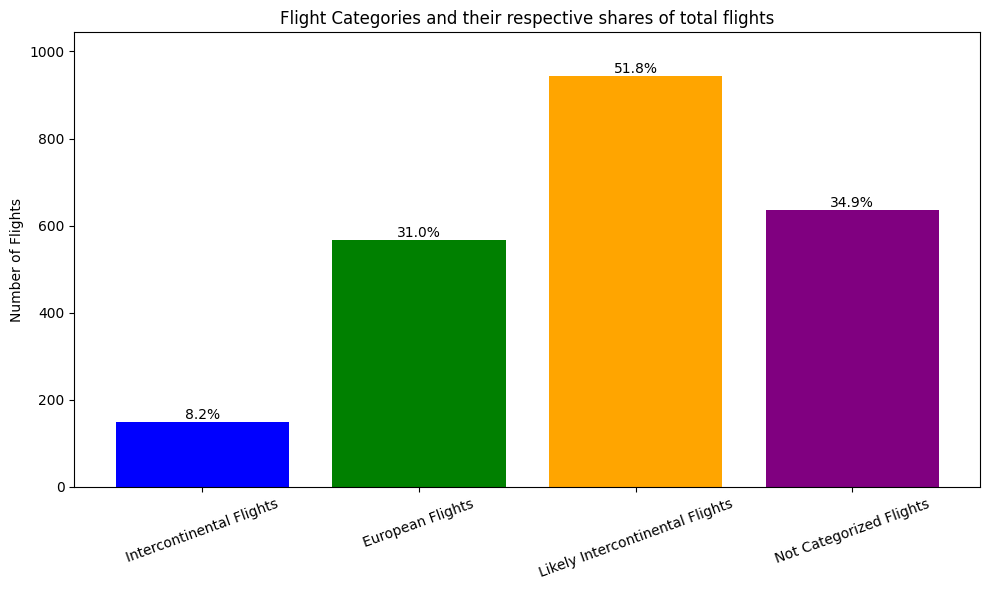

In [321]:
categories = [
    "Intercontinental Flights",
    "European Flights",
    "Likely Intercontinental Flights",
    "Not Categorized Flights"
]

values = [nr_ZRH_intercontinental, nr_ZRH_european, nr_likely_intercontinental_updated, nr_not_categorized]

# Total number of flights for percentage calculation
total_flights = len(data_flights_update)
percentages = [(value / total_flights) * 100 for value in values]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color=['blue', 'green', 'orange', 'purple'])

# Adding percentage labels on top of each bar
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{percentage:.1f}%', ha='center', va='bottom')

# Customize the plot
plt.ylabel('Number of Flights')
plt.title('Flight Categories and their respective shares of total flights')
plt.xticks(rotation=20)
plt.ylim(0, max(values) + 100)

# Show the plot
plt.tight_layout()
plt.show()

## 5.5 Reasoning

>Please be aware, since the data split in ch. 0.3 unique flight numbers are used, therefore the amount of flights may be different to other deployments!

>For the last of the three sub-tasks, the following assumption was made: A 'likely' intercontinental flight with two segments and a layover in Europe is a flight with one hop at a european airport either starting or ending in Europe (e.g, Amsterdam -> London -> New York, as well as New York -> London -> Amsterdam are both connections considered in this category and all of their legs, i.e. incl. their european flight segment will be labgelled as such). Also, the task doesn't specify whether the category must be exclusive, therefore the liberty was taken to decide that also previously labelled flights can be part of a likely intercontinental flight (i.e. flights could exist that are labelled as 'ZRH_european' and 'likely_intercontinental').

Taken these assumptions into consideration, the following steps were followed:
1. Ch. 5.1: Creation of Country / Continent Mapping with the help of the Python library ``countryinfo``
2. Ch. 5.2: Creation of a flight_times dataframe, showing the most recent set of departure and arrival times (fetched by pyflightinfo's ``get_history_by_flight_number()`` function)
3. Ch. 5.3: Classification into the three categories
4. Ch. 5.4: Visualization of results

The first two categories (Intercontinental flights directly to and from Zurich/Switzerland & European flights to and from Zurich/Switzerland) are trivial and can be found by leveraging the created country / continent mapping.

For the last category (Likely intercontinental flights with a European layover) every intercontinental flight starting in europe or arriving in europe was marked as likely intecontinental if this flight had any connecting flights arriving with t-4 (for outbound) or departing with t+4 (for inbound) hours from the same european location.

In the above visualization, one can see that a large set of flights was successfully classified:
- Intercontinental flights directly to and from Zurich/Switzerland: 150 (8.2%)
- European flights to and from Zurich/Switzerland: 566 (31%)
- Likely intercontinental flights with a European layover: 944 (51.8%)

34.9% of all flights could not be categorized, which makes them flights outside of europe without a european layover or simply flights which don't have any connecting flights with a maximum layover time of 4h. Please keep in mind, the categories, may overlap to some degree as explained in the assumptions, therefore adding the percentages results in a higher number than 100%.


# 6. Visualize department flights on a world map - 3 points

## 6.1 Setup

In [ ]:
!pip install cartopy

In [322]:
# setup
data_flights = pd.read_csv('data/t5_FlightData.csv')
data_airports = pd.read_csv('data/t5_AirportData.csv')
flight_times = pd.read_csv('data/t5_FlightTimes.csv')
data_trips = pd.read_csv('data/t1_TripData.csv', sep=';')
total_flight_trip_data = pd.merge(data_flights, data_trips, on='Flight number', how='inner')


## 6.2 Visualizations per department

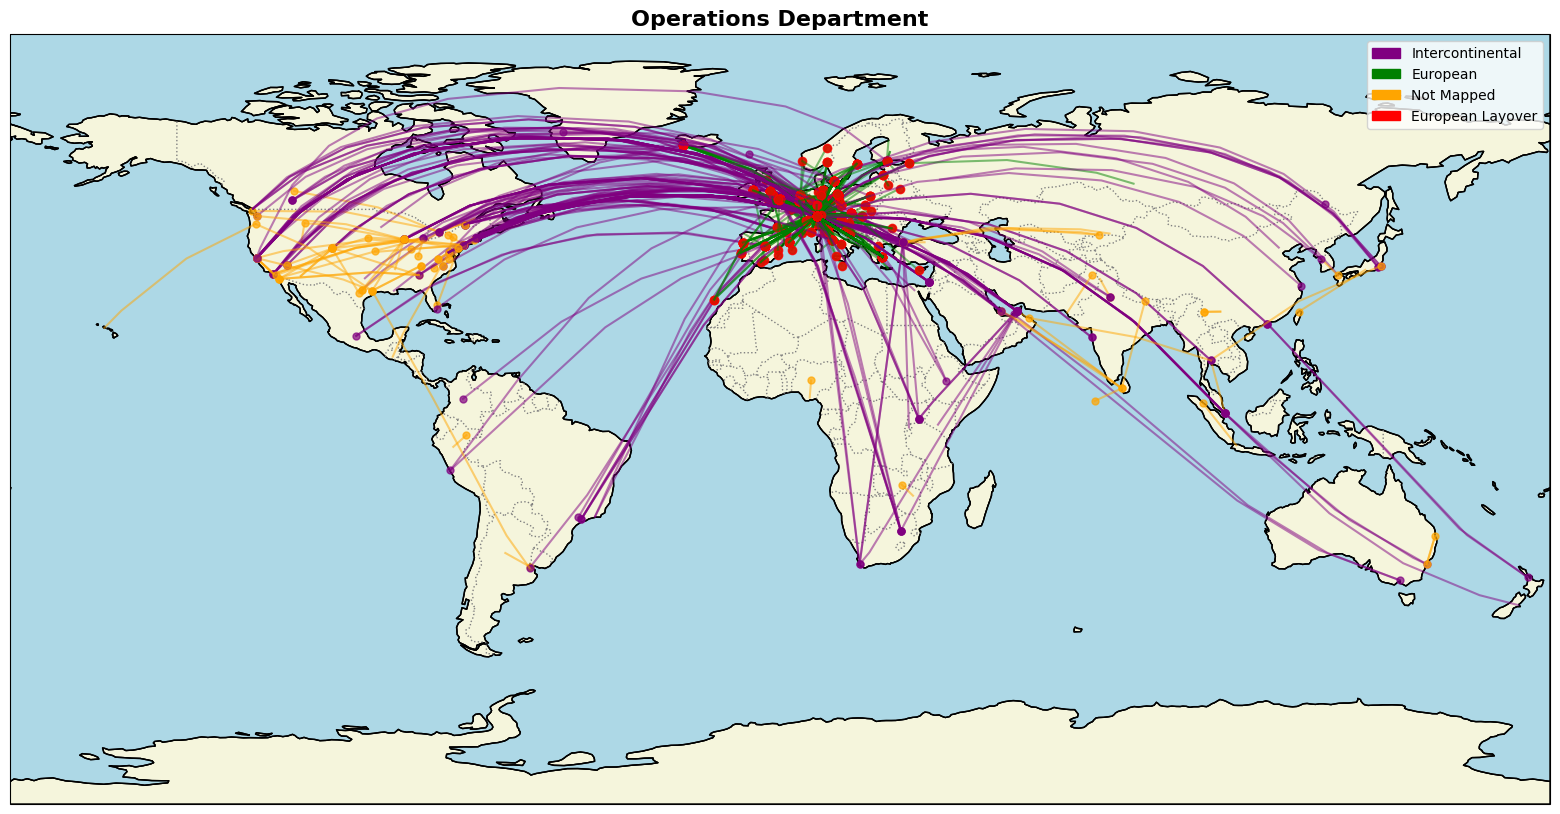

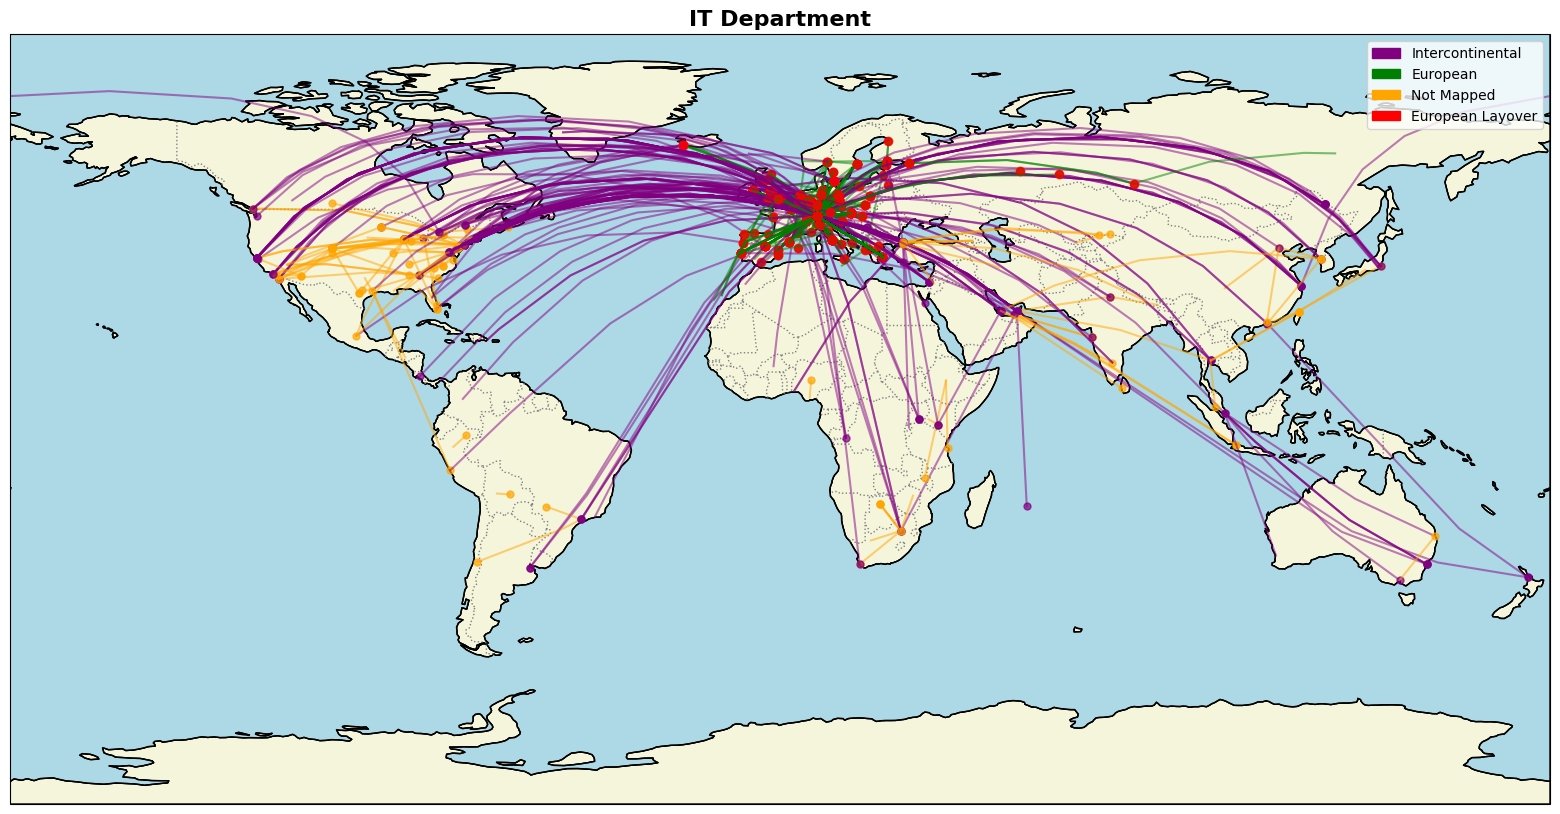

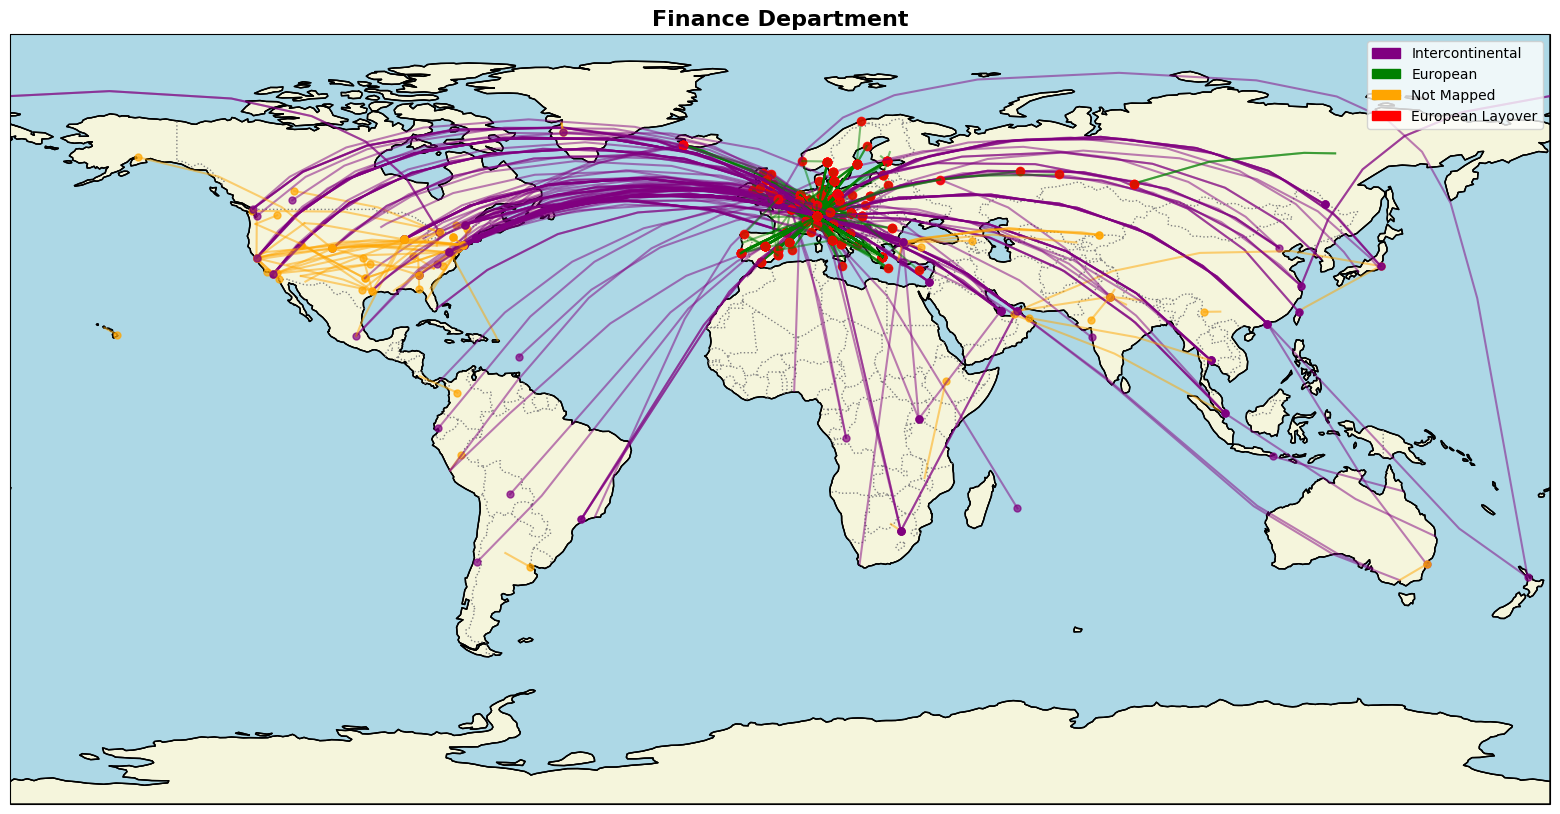

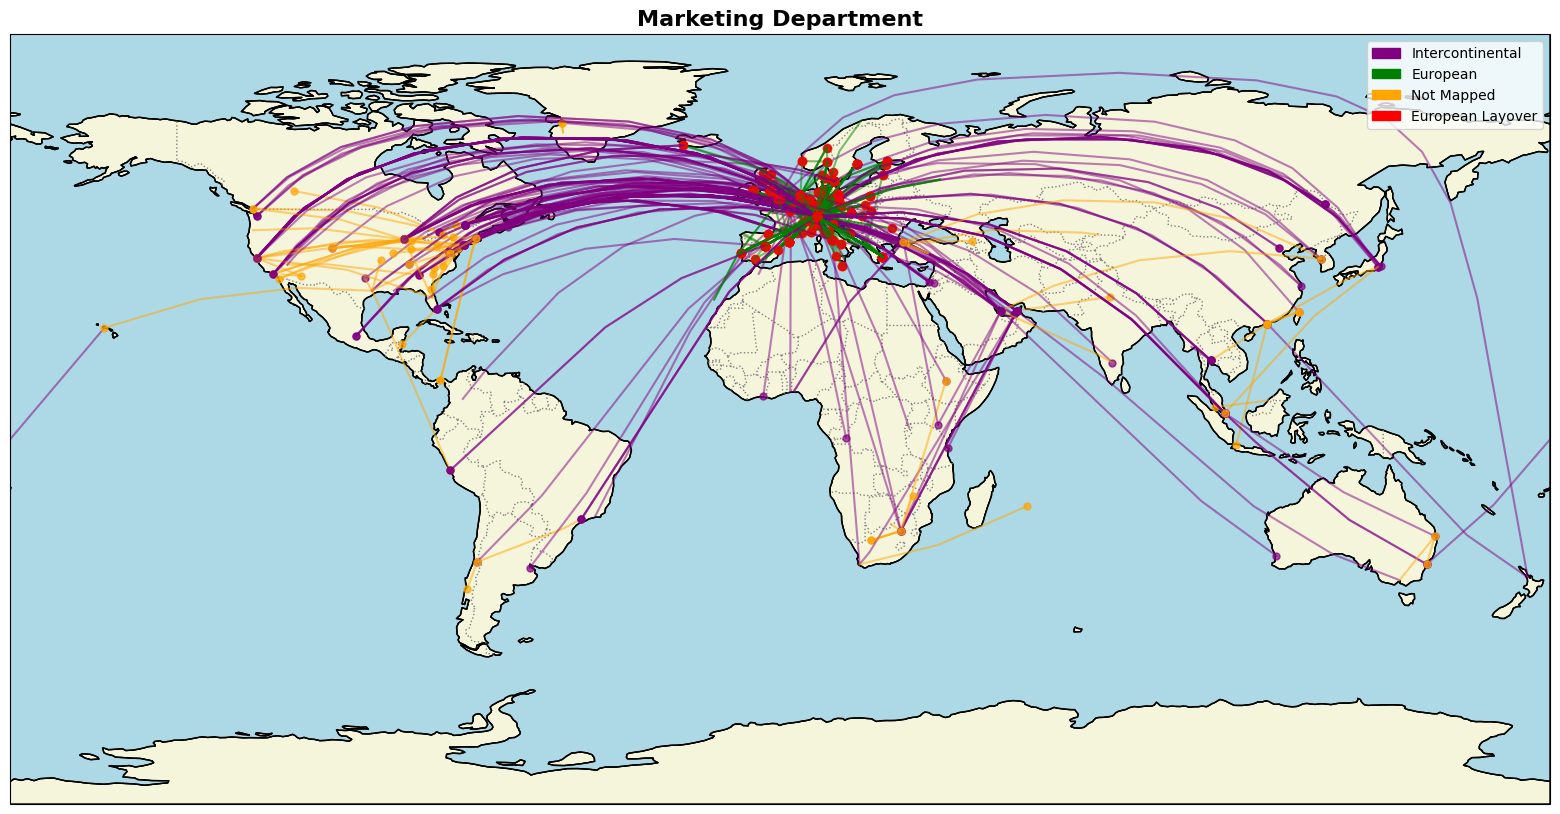

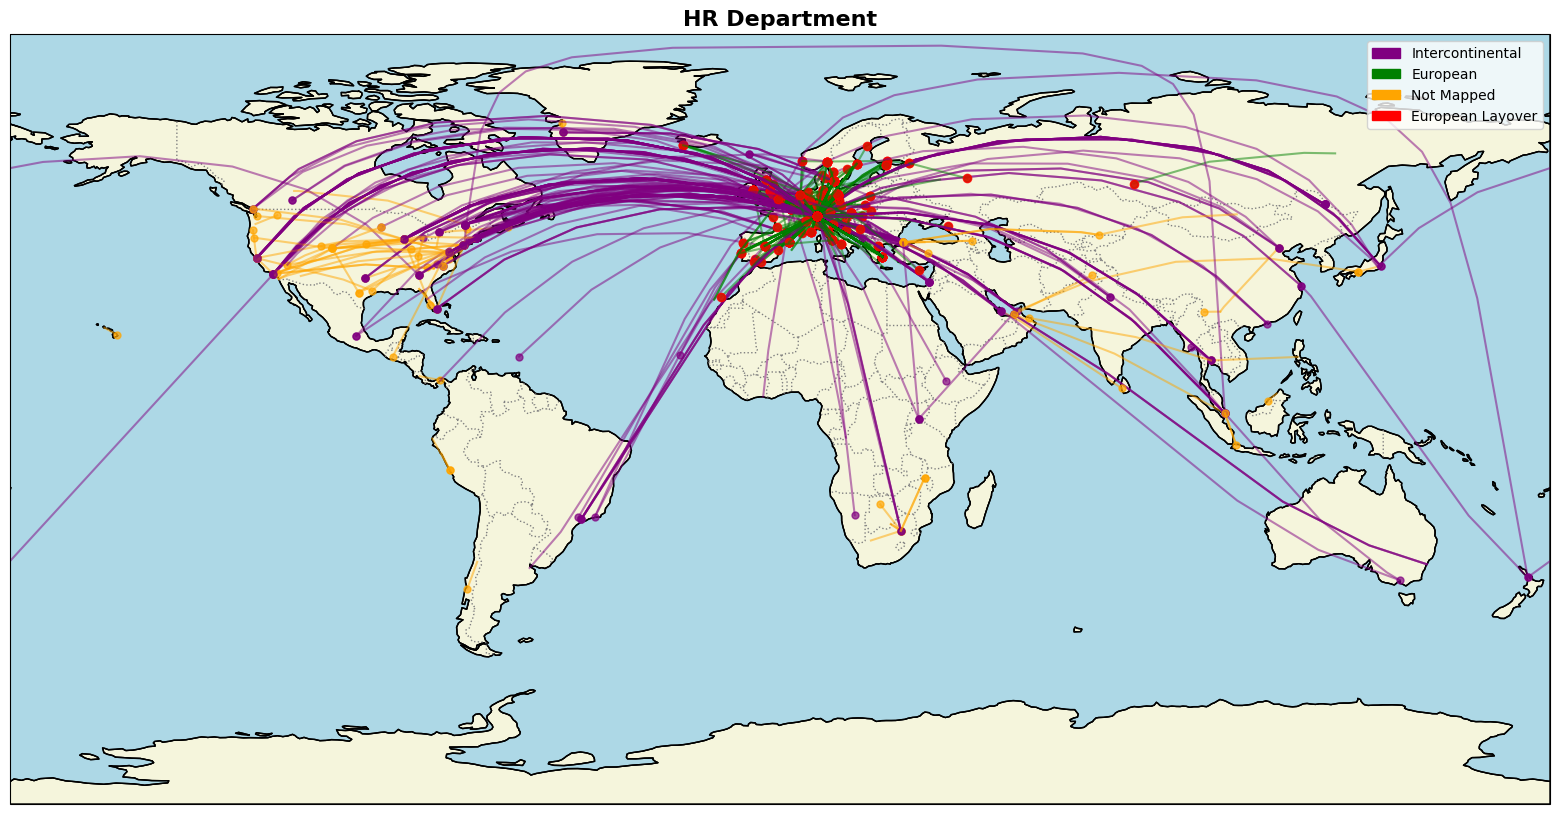

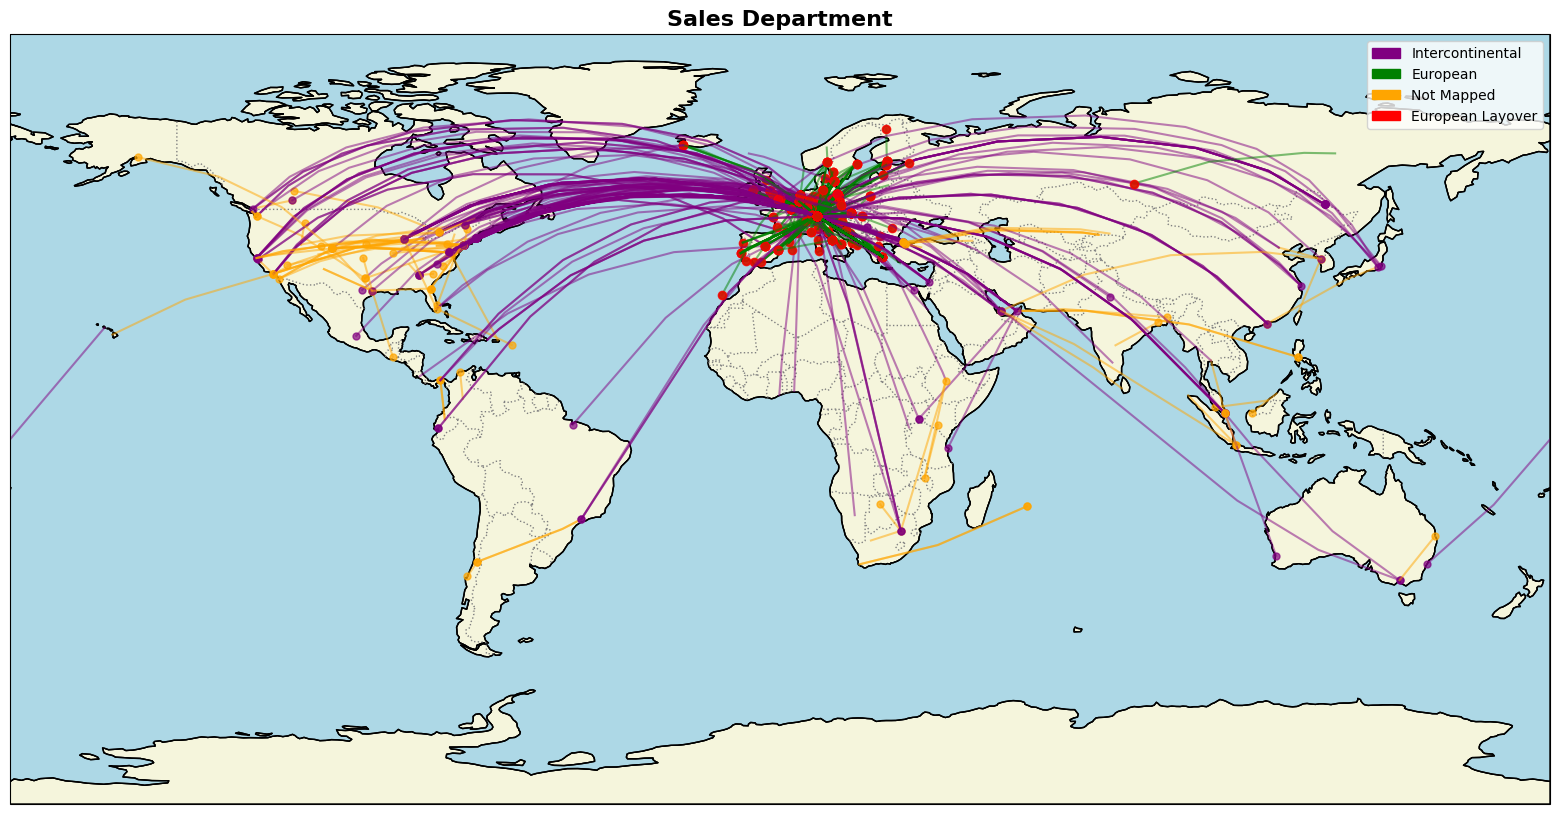

In [332]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

total_flight_trip_data['intercontinental'] = None
total_flight_trip_data['european'] = None
total_flight_trip_data['not_mapped'] = None
total_flight_trip_data['european_layover'] = None

# Function to determine flight classification
def classify_flight(row):
    departure_continent = data_airports[data_airports["iata"]==row["Departure"]]["continent"].values
    destination_continent = data_airports[data_airports["iata"]==row["Destination"]]["continent"].values

    if destination_continent != departure_continent:
        row['intercontinental'] = True
    elif destination_continent == 'Europe' and departure_continent == 'Europe':
        row['european'] = True
    else:
        row['not_mapped'] = True
    return row

# Function to determine potential European layovers
def check_layover(row):
    result = row['likely_intercontinental'] and data_airports[data_airports["iata"]==row["Departure"]]["continent"].values == 'Europe'
    row['european_layover']=result
    return row

total_flight_trip_data = total_flight_trip_data.apply(classify_flight, axis=1)
total_flight_trip_data = total_flight_trip_data.apply(check_layover, axis=1)

# Function to retrieve coordinates
def fetch_coordinates(airport_code):
    airport_info = data_airports[data_airports['iata'] == airport_code]
    if not airport_info.empty:
        return airport_info['longitude'].values[0], airport_info['latitude'].values[0]
    return None

# Function to visualize flight paths
def visualize_flights(df, dept_name):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Set map style
    ax.add_feature(cfeature.LAND, facecolor='beige', edgecolor='black')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
    ax.set_global()

    unmapped = []

    for _, flight in df.iterrows():
        origin_coords = fetch_coordinates(flight['Departure'])
        destination_coords = fetch_coordinates(flight['Destination'])
        
        if origin_coords and destination_coords:
            flight_color = 'purple' if flight['intercontinental'] else 'green' if flight['european'] else 'orange' if flight['not_mapped'] else 'gray'
            ax.plot([origin_coords[0], destination_coords[0]], [origin_coords[1], destination_coords[1]], 
                    color=flight_color, linewidth=1.5, alpha=0.5, transform=ccrs.Geodetic())
            ax.plot(*origin_coords, 'o', color=flight_color, markersize=5, transform=ccrs.PlateCarree(), alpha=0.7)

            if flight['european_layover']:
                ax.plot(*origin_coords, 'o', color='red', markersize=6, transform=ccrs.PlateCarree(), alpha=0.8)
        else:
            unmapped.append((flight['Departure'], flight['Destination']))

    plt.title(f'{dept_name} Department', fontsize=16, fontweight='bold')

    legend_elements = [
        mpatches.Patch(color='purple', label='Intercontinental'),
        mpatches.Patch(color='green', label='European'),
        mpatches.Patch(color='orange', label='Not Mapped'),
        mpatches.Patch(color='red', label='European Layover')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right')
    plt.show()
    
    if unmapped:
        print(f"Unmapped routes for {dept_name}: {unmapped}")

# Plot for each department
departments = total_flight_trip_data['Department'].unique()

for department in departments:
    department_df = total_flight_trip_data[total_flight_trip_data['Department'] == department]
    visualize_flights(department_df, department)


## 6.3 Reasoning

>Assumption: The types of flights are new type of flights than the 3 categories created in chapter 5.

Based on the data created in Exercise 5, 4 new columns were created to distinguish different types of flights:
- `intercontinental:` all flights where destination continent is not the same as departure continent
- `european:` all flights where destination continent and departure continents are labelled to be Europe
- `european_layover:` Every flight that has previously been labelled as `likely_intercontinental` (see Ch. 5) and where its departure airport is located in Europe
- `not_mapped:` Every other flight (most likely flights starting and ending outside of Europe)

Once this mapping has been done, the visualizations are built for each department using `cartopy`(to visualize flight pahts) and `mathplotlib` (as the basis for the visualization).

European layovers are visualized with red dots. Flights of the category `not_mapped`are visualized leveraging orange color.

# 7. Compare departments by their CO2 emissions for European and Intercontinental Flights- 2 points

## 7.1 Setup and data conversion

In [324]:

total_flight_trip_data['CO2 RFI 2 + emissions jet fuel production 15.2% [t]'] = pd.to_numeric(
    total_flight_trip_data['CO2 RFI 2 + emissions jet fuel production 15.2% [t]'],
    errors='coerce'  # Converts non-numeric to NaN
)

# Check for any NaN values after conversion
nan_count = total_flight_trip_data['CO2 RFI 2 + emissions jet fuel production 15.2% [t]'].isna().sum()
if nan_count > 0:
    print(f'Number of NaN values after conversion: {nan_count}')

# Drop rows with NaN values in the specific column
european_emissions_cleaned = total_flight_trip_data.dropna(subset=['CO2 RFI 2 + emissions jet fuel production 15.2% [t]'])

# Calculate the sum
total_emissions = european_emissions_cleaned['CO2 RFI 2 + emissions jet fuel production 15.2% [t]'].sum()
print(f'Total CO2 emissions: {total_emissions}')

print(total_flight_trip_data['CO2 RFI 2 + emissions jet fuel production 15.2% [t]'].sum())

Number of NaN values after conversion: 1068
Total CO2 emissions: 3887.724017472
3887.724017472


## 7.2 Data visualization per Department

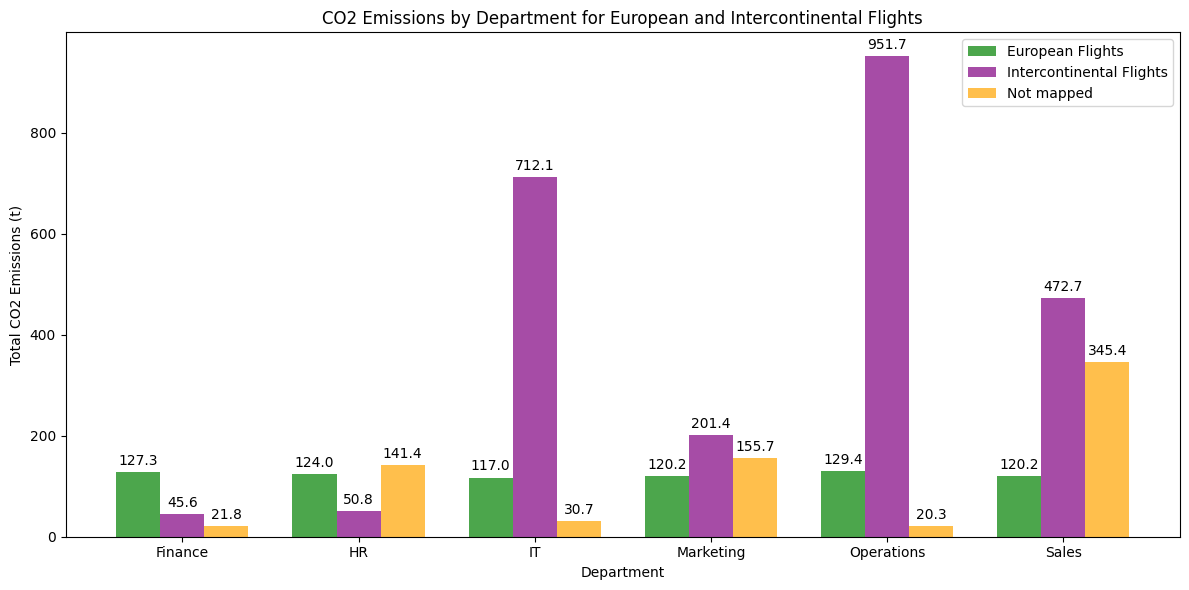

In [325]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you already have the emissions data as described

# Filter for European and Intercontinental flights
european_flights = total_flight_trip_data[total_flight_trip_data['european'] == True]
intercontinental_flights = total_flight_trip_data[total_flight_trip_data['intercontinental'] == True]
not_mapped_flights = total_flight_trip_data[total_flight_trip_data['not_mapped'] == True]

# Group by Department and sum CO2 emissions
european_emissions = european_flights.groupby('Department')[
    'CO2 RFI 2 + emissions jet fuel production 15.2% [t]'].sum().reset_index()

intercontinental_emissions = intercontinental_flights.groupby('Department')[
    'CO2 RFI 2 + emissions jet fuel production 15.2% [t]'].sum().reset_index()

not_mapped_emissions = not_mapped_flights.groupby('Department')[
    'CO2 RFI 2 + emissions jet fuel production 15.2% [t]'].sum().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

# Bar positions for each category
x = range(len(european_emissions))

# Bar width
bar_width = 0.25

# Plot European emissions
european_bars = ax.bar(x, european_emissions['CO2 RFI 2 + emissions jet fuel production 15.2% [t]'], 
       width=bar_width, label='European Flights', color='green', alpha=0.7)

# Plot Intercontinental emissions
intercontinental_bars = ax.bar([p + bar_width for p in x], intercontinental_emissions['CO2 RFI 2 + emissions jet fuel production 15.2% [t]'], 
       width=bar_width, label='Intercontinental Flights', color='purple', alpha=0.7)

# Plot not mapped emissions
not_mapped_bars = ax.bar([p + 2 * bar_width for p in x], not_mapped_emissions['CO2 RFI 2 + emissions jet fuel production 15.2% [t]'], 
       width=bar_width, label='Not mapped', color='orange', alpha=0.7)

# Labels and title
ax.set_xlabel('Department')
ax.set_ylabel('Total CO2 Emissions (t)')
ax.set_title('CO2 Emissions by Department for European and Intercontinental Flights')
ax.set_xticks([p + bar_width for p in x])
ax.set_xticklabels(european_emissions['Department'])
ax.legend()

# Annotate bars with their respective sums
for bars in [european_bars, intercontinental_bars, not_mapped_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',  # Format the height value
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # Position above the bar
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 7.3 Reasoning

In this task a comprehensive dataset (merged flight & trip data), `total_flight_trip_data` was utilized, to calculate total emissions for three categories: European flights, Intercontinental flights, and flights that are not mapped.

Initially, non-numeric values in the CO2 emissions column are converted to numeric format, ensuring accurate calculations by dropping rows containing NaN values. The emissions data is then grouped by department, allowing for a clear comparison of total emissions across different flight categories.

Using bar charts, the findings are visually represented, illustrating the total CO2 emissions for each department for European and Intercontinental flights, with distinct colors to differentiate between categories. The heights of the bars are annotated with their respective emissions values, enhancing the clarity of the results.

Missing emission data is dropped, as no formula was provided on how to calculate those values.

# 8. References
For this project a number of Python libraries and their online documentation were used, namely:
- pandas
- pyflightdata
- matplotlib
- seaborn
- logging
- cartopy
- countryinfo

Additionally, the class slides up to this point (Oct 26th) were consulted to serve as best practices.

Also, in the conduct of this project, specific artificial intelligence tools, namely chatGPT, were used to assist with Python programming and Python library specific syntax. While these tools have augmented my capabilities, any conclusions drawn and the actual coding, as well as troubleshooting, are a result of my own insights and skills.